# In this notebook, we will grab Google trends data related to how often "California Wild Fire" and "Farmers Markets" have been googled

The idea is that high levels of search activity surrounding these keywords in the days prior to a farmers market event may be predictive of overall sales on the day of the market itself


In [26]:

from datetime import datetime, timedelta, date, time
import pandas as pd
import time
import numpy as np
import os
from time import sleep
from matplotlib import pyplot as plt

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError


#functions to fetch google trends data

def _fetch_data(trendreq, kw_list, timeframe='today 3-m', cat=0, geo='', gprop='') -> pd.DataFrame:
    
    """Download google trends data using pytrends TrendReq and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            trendreq.build_payload(kw_list=kw_list, timeframe=timeframe, cat=cat, geo=geo, gprop=gprop)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return trendreq.interest_over_time()

def get_daily_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', delta=269, overlap=100, sleep=0, 
                    tz=0, verbose=False) ->pd.DataFrame:

    """Stich and scale consecutive daily trends data between start and end date.
    This function will first download piece-wise google trends data and then 
    scale each piece using the overlapped period. 
        Parameters
        ----------
        trendreq : TrendReq
            a pytrends TrendReq object
        keyword: str
            currently only support single keyword, without bracket
        start: str
            starting date in string format:YYYY-MM-DD (e.g.2017-02-19)
        end: str
            ending date in string format:YYYY-MM-DD (e.g.2017-02-19)
        cat, geo, gprop, sleep: 
            same as defined in pytrends
        delta: int
            The length(days) of each timeframe fragment for fetching google trends data, 
            need to be <269 in order to obtain daily data.
        overlap: int
            The length(days) of the overlap period used for scaling/normalization
        tz: int
            The timezone shift in minute relative to the UTC+0 (google trends default).
            For example, correcting for UTC+8 is 480, and UTC-6 is -360 
    """
    
    start_d = datetime.strptime(start, '%Y-%m-%d')
    init_end_d = end_d = datetime.strptime(end, '%Y-%m-%d')
    init_end_d.replace(hour=23, minute=59, second=59)    
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)

    itr_d = end_d - delta
    overlap_start = None

    df = pd.DataFrame()
    ol = pd.DataFrame()
    
    while end_d > start_d:
        tf = itr_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
        if verbose: print('Fetching \''+keyword+'\' for period:'+tf)
        temp = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        temp.drop(columns=['isPartial'], inplace=True)
        temp.columns.values[0] = tf
        ol_temp = temp.copy()
        ol_temp.iloc[:,:] = None
        if overlap_start is not None:  # not first iteration
            if verbose: print('Normalize by overlapping period:'+overlap_start.strftime('%Y-%m-%d'), end_d.strftime('%Y-%m-%d'))
            #normalize using the maximum value of the overlapped period
            y1 = temp.loc[overlap_start:end_d].iloc[:,0].values.max()
            y2 = df.loc[overlap_start:end_d].iloc[:,-1].values.max()
            coef = y2/y1
            temp = temp * coef
            ol_temp.loc[overlap_start:end_d, :] = 1 

        df = pd.concat([df,temp], axis=1)
        ol = pd.concat([ol, ol_temp], axis=1)
        # shift the timeframe for next iteration
        overlap_start = itr_d
        end_d -= (delta-overlap)
        itr_d -= (delta-overlap)
        # in case of short query interval getting banned by server
        time.sleep(sleep)
    
    df.sort_index(inplace=True)
    ol.sort_index(inplace=True)
    #The daily trend data is missing the most recent 3-days data, need to complete with hourly data
    if df.index.max() < init_end_d : 
        tf = 'now 7-d'
        hourly = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        hourly.drop(columns=['isPartial'], inplace=True)
        
        #convert hourly data to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        
        #check whether the first day data is complete (i.e. has 24 hours)
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        if daily.iloc[0].loc['hours'] != 24: daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [tf]
        
        ol_temp = daily.copy()
        ol_temp.iloc[:,:] = None
        # find the overlapping date
        intersect = df.index.intersection(daily.index)
        if verbose: print('Normalize by overlapping period:'+(intersect.min().strftime('%Y-%m-%d'))+' '+(intersect.max().strftime('%Y-%m-%d')))
        # scaling use the overlapped today-4 to today-7 data
        coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        ol_temp.loc[intersect,:] = 1
        
        df = pd.concat([daily, df], axis=1)
        ol = pd.concat([ol_temp, ol], axis=1)

    # taking averages for overlapped period
    df = df.mean(axis=1)
    ol = ol.max(axis=1)
    # merge the two dataframe (trend data and overlap flag)
    df = pd.concat([df,ol], axis=1)
    df.columns = [keyword,'overlap']
    # Correct the timezone difference
    df.index = df.index + timedelta(minutes=tz)
    df = df[start_d:init_end_d]
    # re-normalized to the overall maximum value to have max =100
    df[keyword] = (100*df[keyword]/df[keyword].max()).round(decimals=0)
    
    return df

# Initialize PyTrends object

In [27]:
pytrend_object=TrendReq()

# Extract 'Farmers Market' search activity

In [28]:
gtrends_fm_data=get_daily_trend(pytrend_object, 'farmers market', '2014-01-01', datetime.now().strftime("%Y-%m-%d"), cat=0, \
                    geo='US-CA-803', gprop='', delta=269, overlap=100, sleep=0, \
                    tz=0, verbose=False)

# Extract 'Los Angeles Wildfire' search activity

In [29]:
gtrends_fire_data=get_daily_trend(pytrend_object, 'Los Angeles Wildfire', '2014-01-01', datetime.now().strftime("%Y-%m-%d"), cat=0, \
                    geo='US-CA-803', gprop='', delta=269, overlap=100, sleep=0, \
                    tz=0, verbose=False)

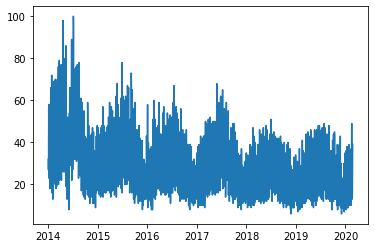

In [30]:
#plot farmers market daily searchers 
plt.figure()
plt.plot(gtrends_fm_data['farmers market'])

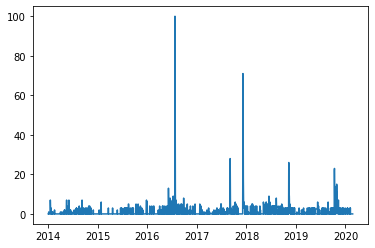

In [31]:
plt.figure()
plt.plot(gtrends_fire_data['Los Angeles Wildfire'])

In [32]:
#combine data into a single data frame
joined_gtrends=gtrends_fm_data.join(gtrends_fire_data,lsuffix='date',rsuffix='date')[['farmers market','Los Angeles Wildfire']].reset_index()

In [33]:
#now save file
os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Feature_Data_Files')
joined_gtrends.to_pickle('gTrends.pkl')